In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import os
import logging
import json
import random

import numpy as np
import json
from tqdm.notebook import tqdm


# Set-up

## Load data

In [14]:
# Load imagenet


# Path to your imagenet_class.json file
json_file_path = '/home/mila/s/sonia.joseph/ViT-Planetarium/my_draft/test_nbs/imagenet_class_index.json'
imagenet_path = '/network/datasets/imagenet.var/imagenet_torchvision/val/'

# Load the JSON file into a Python dictionary
with open(json_file_path, 'r') as file:
    num_to_word_dict = json.load(file)

# Create a reverse dictionary for word to number mapping
word_to_num_dict = {}
for num, words in num_to_word_dict.items():
    for word in words:  # Assuming each entry in num_to_word_dict is a list of words
        word_to_num_dict[word] = num

# Function to get the class name from a label
def get_class_name(label):
    # Assuming the label maps to a list of class names
    return num_to_word_dict.get(str(label), ["Unknown label"])[1]

# Function to get the label from a class name
def get_label(class_name):
    return word_to_num_dict.get(class_name, "Unknown class name")

# Get class names
imagenet_class_nums = np.arange(0, 1000, 1)
imagenet_class_names = ["{}".format(get_class_name(i)) for i in imagenet_class_nums]

# Set the seed. You don't need indices if data is loaded in same order every time.
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# # Function to load images based on saved order
# def load_images_in_order(indices_path, imagenet_dataset):
#     indices = np.load(indices_path)
#     subset_dataset = Subset(imagenet_dataset, indices)
#     data_loader = DataLoader(subset_dataset, batch_size=1)
#     return data_loader

# # Load the ImageNet dataset
imagenet_data = datasets.ImageFolder(imagenet_path, transform=data_transforms)
# data_loader = load_images_in_order('imagenet_sample_indices.npy', imagenet_data)


## Load model

In [3]:
# from PIL import Image
# import requests
# import matplotlib.pyplot as plt

# from transformers import CLIPProcessor, CLIPModel

# model = CLIPModel.from_pretrained("wkcn/TinyCLIP-ViT-8M-16-Text-3M-YFCC15M")
# processor = CLIPProcessor.from_pretrained("wkcn/TinyCLIP-ViT-8M-16-Text-3M-YFCC15M", do_rescale=False) # Make sure the do_rescale is false for pytorch datasets

# images, labels = next(iter(data_loader))

# idx = 0

# inputs = processor(text=imagenet_class_names, images=images, return_tensors="pt", padding=True)
# outputs = model(**inputs)
# logits_per_image = outputs.logits_per_image # this is the image-text similarity score
# probs = logits_per_image.softmax(dim=1) # we can take the softmax to get the label probabilities
# # predicted_class = imagenet_class_names[probs.argmax(dim=1)]
# predicted_indices = probs.argmax(dim=1)

# plt.imshow(images[idx].permute(1, 2, 0))
# plt.title(f"Predicted: {get_class_name(predicted_indices[idx].item())}. True: {get_class_name(labels[idx].item())}")

# Patch/image-level analysis for maximally activating neurons

Look at maximally activating neurons with patch/image as the individual unit.

Loaded from precached activations from 500 randomly sampled ImageNet points.

In [4]:
import pandas as pd
import os

layer_num = 7

save_path = f'/network/scratch/s/sonia.joseph/clip_mechinterp/tinyclip/mini_dataset/'
file_name = f'mlp_fc1_{layer_num}.npz'

loaded = pd.read_parquet(os.path.join(save_path, file_name))


### Get standard deviation of patch value 

On the neuron level (aggregating across all images and patches for that neuron)**

In [5]:
# Calculate mean and standard deviation for 'activation_value' grouped by 'neuron_idx'
grouped = loaded.groupby('neuron_idx')['activation_value']
mean_per_neuron = grouped.transform('mean')
std_dev_per_neuron = grouped.transform('std')

# Calculate the z-score (number of standard deviations from the mean)
loaded['activation_value_sds'] = (loaded['activation_value'] - mean_per_neuron) / std_dev_per_neuron

# Replace NaN and infinite values (which can occur if std_dev is zero) with zero
loaded['activation_value_sds'].replace([np.inf, -np.inf, np.nan], 0, inplace=True)


# Sort by z-score
sorted_df = loaded.sort_values(by=['activation_value_sds'], ascending=False)

In [7]:
sorted_df.head(10).style.background_gradient("coolwarm") 

In [8]:
sorted_df.tail(10).style.background_gradient("coolwarm")

In [10]:
filtered_df = sorted_df[sorted_df['neuron_idx'] == 7]
filtered_df.head(14).style.background_gradient("coolwarm")

### Return top 5 patches per neuron (based on SD)

In [9]:
# # Ensure 'neuron_idx' is not part of the index
# top_patches_per_neuron = loaded.reset_index(drop=True)

# # Group by 'neuron_idx', then sort within groups by 'activation_value'
# grouped = top_patches_per_neuron.groupby('neuron_idx', group_keys=False).apply(lambda x: x.sort_values('activation_value_sds', ascending=False))

# # Get top 5 entries for each neuron
# top_5_per_neuron = grouped.groupby('neuron_idx').head(5)

# # Selecting the relevant columns
# top_5_per_neuron = top_5_per_neuron[['batch_idx', 'neuron_idx', 'patch_idx', 'class_name', 'predicted', 'activation_value', 'activation_value_sds']]


In [11]:
# top_5_per_neuron.head(10).style.background_gradient("coolwarm")


In [12]:
# Now go back and all the activations for neuron 4
sorted_df[sorted_df['neuron_idx'] == 964].head(15).style.background_gradient("coolwarm")

# Neuron 128 appears to like glasses. Let's print out top 10 patches for this neuron.


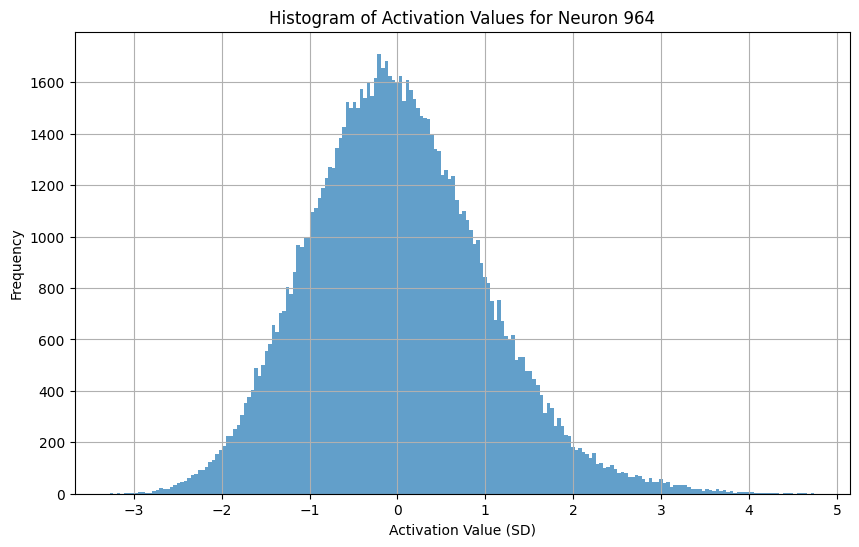

In [13]:
import pandas as pd
import matplotlib.pyplot as plt


# Should this be in log scale?

neuron_of_interest = 964

# Filter the DataFrame to only include the neuron of interest
filtered_df = loaded[loaded['neuron_idx'] == neuron_of_interest]

# Create a histogram of the activation values
plt.figure(figsize=(10, 6))
plt.hist(filtered_df['activation_value_sds'], bins=200, alpha=0.7)
plt.title(f'Histogram of Activation Values for Neuron {neuron_of_interest}')
plt.xlabel('Activation Value (SD)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Do this in log scale? 


### Visualize heatmap for specific image + neuron

In [16]:
import pandas as pd


def plot_image_patch_heatmap(activation_values_array, image, specific_neuron_idx, image_size=224, pixel_num=14):

    activation_values_array = activation_values_array.reshape(pixel_num, pixel_num)

    # Create a heatmap overlay
    heatmap = np.zeros((image_size, image_size))
    patch_size = image_size // pixel_num

    for i in range(pixel_num):
        for j in range(pixel_num):
            heatmap[i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size] = activation_values_array[i, j]

    # Plotting the image with the heatmap overlay
    fig, ax = plt.subplots()
    ax.imshow(image.permute(1,2,0))
    ax.imshow(heatmap, cmap='viridis', alpha=0.6)  # Overlaying the heatmap

    # Removing axes
    ax.axis('off')

    min_activation = activation_values_array.min()
    max_activation = activation_values_array.max()

    # Adding colorbar for the heatmap
    plt.colorbar(plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=min_activation, vmax=max_activation)), ax=ax, orientation='vertical')

    plt.title("Neuron {}'s Activation Values for Image {}".format(specific_neuron_idx, ""))
    plt.show()




In [12]:
def get_image_and_activations_by_id(specific_neuron_idx, specific_image_idx):
    image, label = load_specific_image(imagenet_data, random_indices, specific_image_idx)

    filtered_df = loaded[(loaded['batch_idx'] == specific_image_idx) & 
                                (loaded['neuron_idx'] == specific_neuron_idx)]

    activation_values = filtered_df['activation_value_sds']

    activation_values_array = activation_values.to_numpy()[1:]

    return image, activation_values_array


# Load saved indices
random_indices = np.load('imagenet_sample_indices.npy')

# Function to load a specific image
def load_specific_image(dataset, indices, order):
    specific_index = indices[order]  # Subtract 1 because list indices start at 0
    image, label = dataset[specific_index]
    return image, label


Top 10 Unique Class Names: ['fountain', 'dock', 'Arabian_camel', 'lakeside', 'Brittany_spaniel', 'torch', 'mountain_bike', 'wire-haired_fox_terrier', 'warplane', 'planetarium', 'coil', 'turnstile', 'bicycle-built-for-two', 'cannon', 'cricket', 'recreational_vehicle', 'pirate', 'submarine', 'boathouse', 'mosquito_net', 'rifle', 'sorrel', 'Rottweiler', 'bustard', 'scale', 'hoopskirt', 'tub', 'bannister', 'gondola', 'projectile']
Corresponding Activations: [1.9586100578308105, 1.938618779182434, 1.73380446434021, 1.6209371089935303, 1.614076852798462, 1.5951135158538818, 1.5944346189498901, 1.4693186283111572, 1.4666788578033447, 1.446138858795166, 1.4453377723693848, 1.4241769313812256, 1.4124608039855957, 1.4074161052703857, 1.407106637954712, 1.3877812623977661, 1.3386986255645752, 1.3138041496276855, 1.2999153137207031, 1.281222939491272, 1.2777295112609863, 1.2683918476104736, 1.2612967491149902, 1.2605167627334595, 1.240002155303955, 1.228288173675537, 1.2243452072143555, 1.20001935

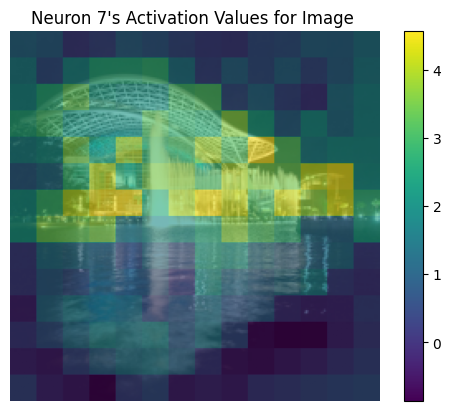

Class Name: fountain
Activation Value: 1.9586100578308105
Batch Index: 48



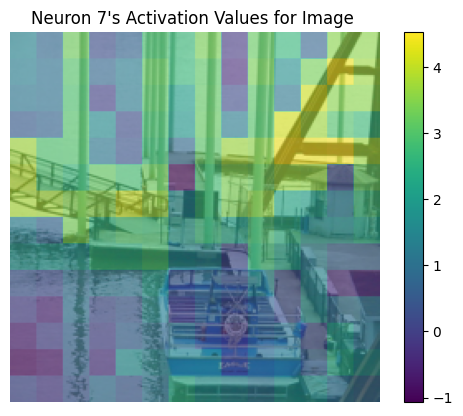

Class Name: dock
Activation Value: 1.938618779182434
Batch Index: 73



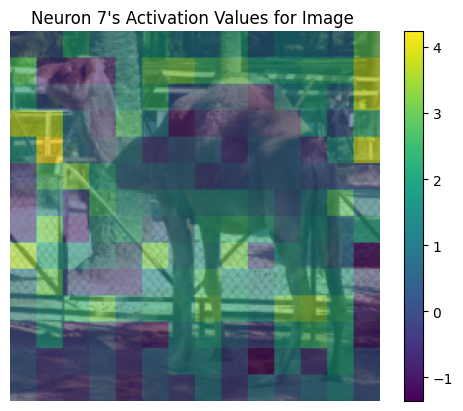

Class Name: Arabian_camel
Activation Value: 1.73380446434021
Batch Index: 78



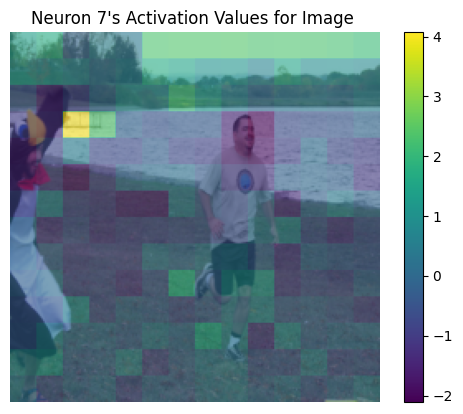

Class Name: lakeside
Activation Value: 1.6209371089935303
Batch Index: 289



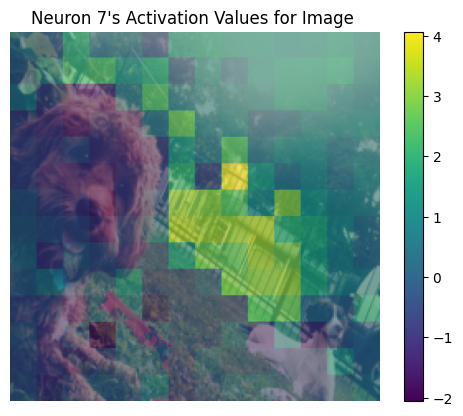

Class Name: Brittany_spaniel
Activation Value: 1.614076852798462
Batch Index: 259



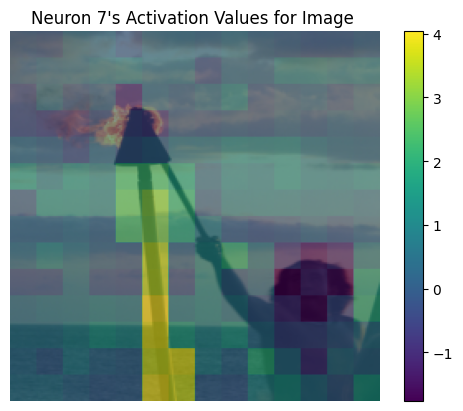

Class Name: torch
Activation Value: 1.5951135158538818
Batch Index: 10



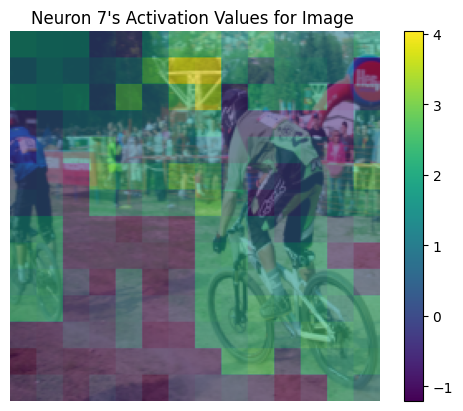

Class Name: mountain_bike
Activation Value: 1.5944346189498901
Batch Index: 0



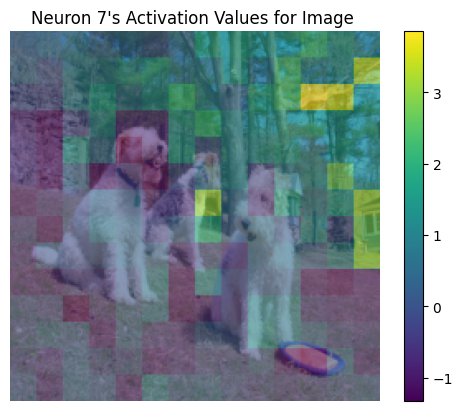

Class Name: wire-haired_fox_terrier
Activation Value: 1.4693186283111572
Batch Index: 42



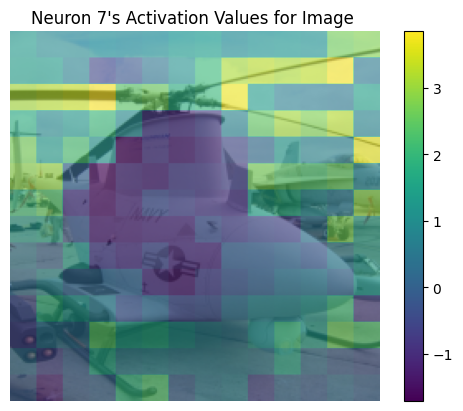

Class Name: warplane
Activation Value: 1.4666788578033447
Batch Index: 239



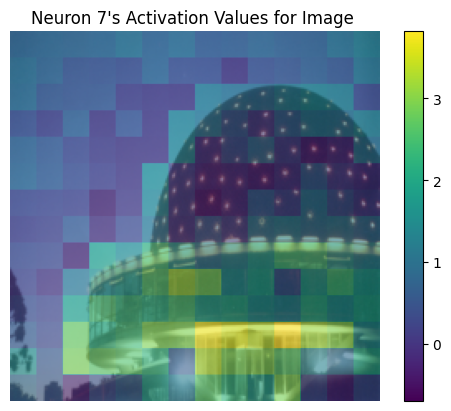

Class Name: planetarium
Activation Value: 1.446138858795166
Batch Index: 140



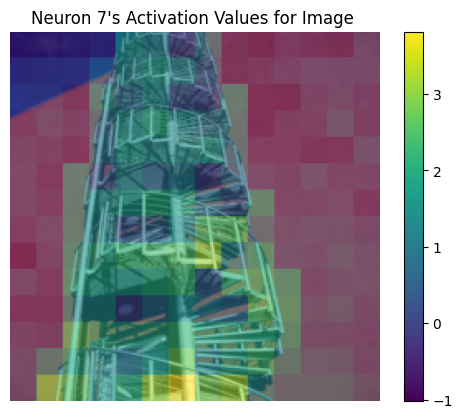

Class Name: coil
Activation Value: 1.4453377723693848
Batch Index: 444



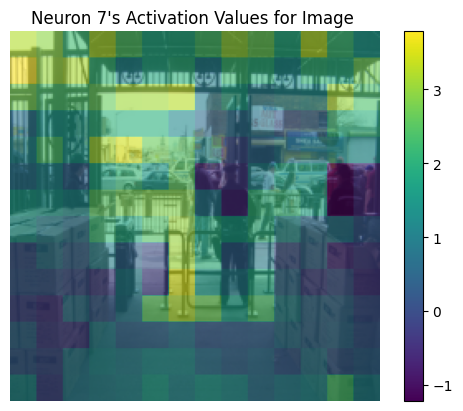

Class Name: turnstile
Activation Value: 1.4241769313812256
Batch Index: 282



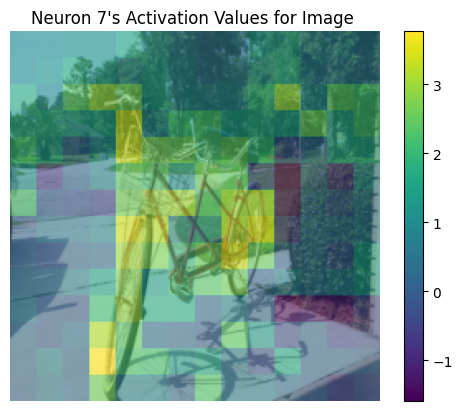

Class Name: bicycle-built-for-two
Activation Value: 1.4124608039855957
Batch Index: 200



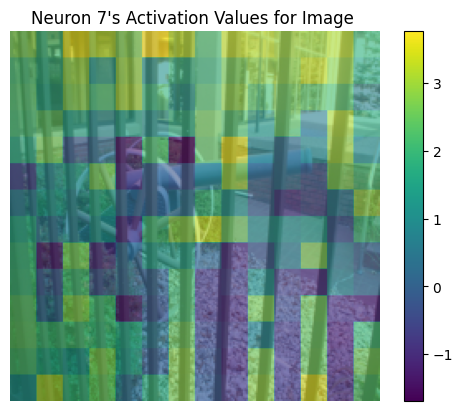

Class Name: cannon
Activation Value: 1.4074161052703857
Batch Index: 423



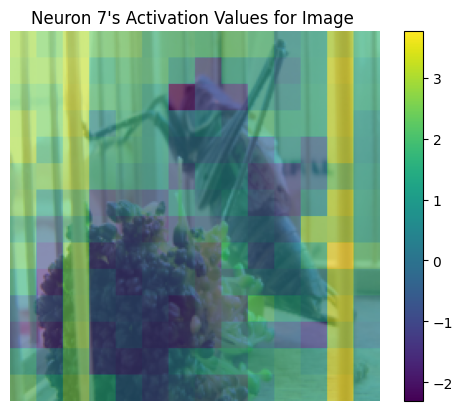

Class Name: cricket
Activation Value: 1.407106637954712
Batch Index: 132



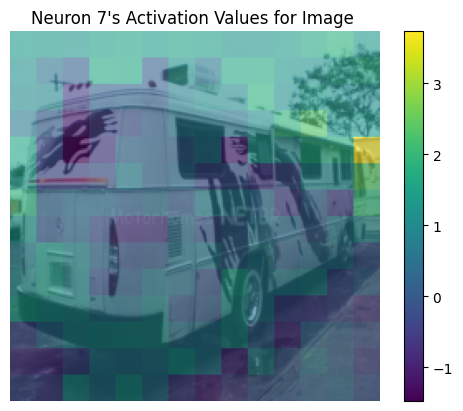

Class Name: recreational_vehicle
Activation Value: 1.3877812623977661
Batch Index: 364



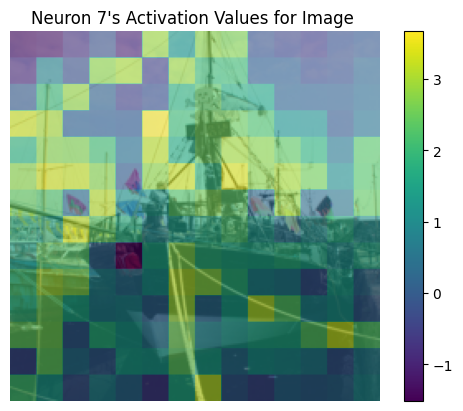

Class Name: pirate
Activation Value: 1.3386986255645752
Batch Index: 418



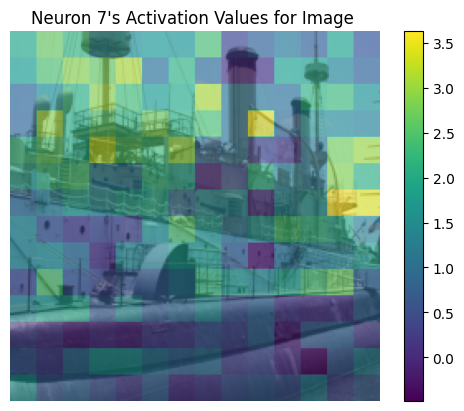

Class Name: submarine
Activation Value: 1.3138041496276855
Batch Index: 235



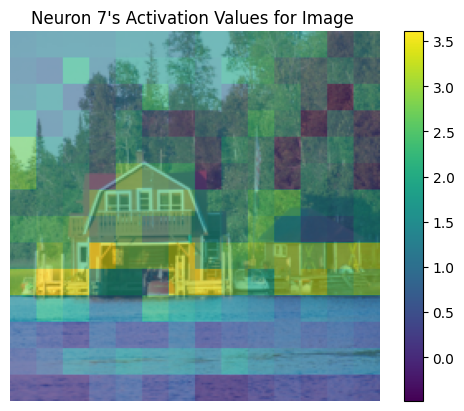

Class Name: boathouse
Activation Value: 1.2999153137207031
Batch Index: 374



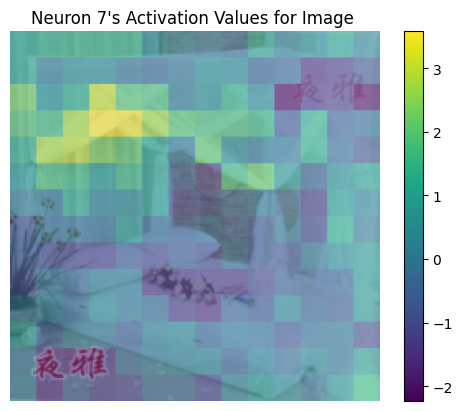

Class Name: mosquito_net
Activation Value: 1.281222939491272
Batch Index: 324



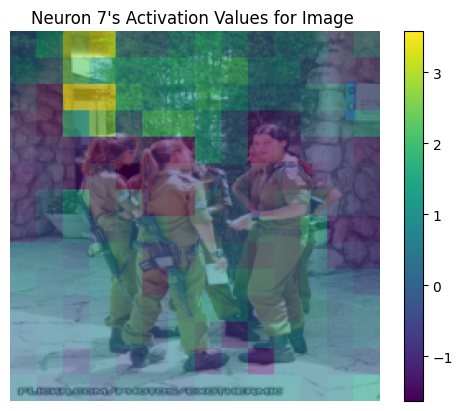

Class Name: rifle
Activation Value: 1.2777295112609863
Batch Index: 136



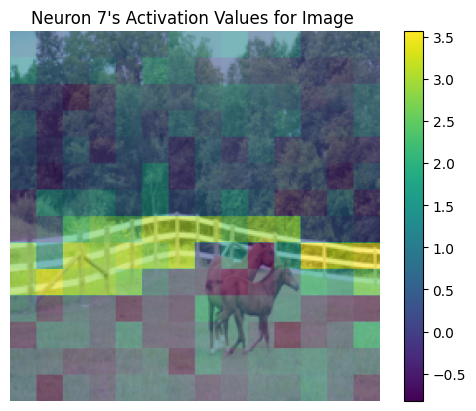

Class Name: sorrel
Activation Value: 1.2683918476104736
Batch Index: 176



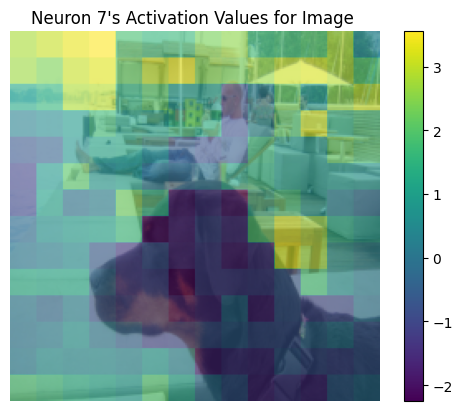

Class Name: Rottweiler
Activation Value: 1.2612967491149902
Batch Index: 395



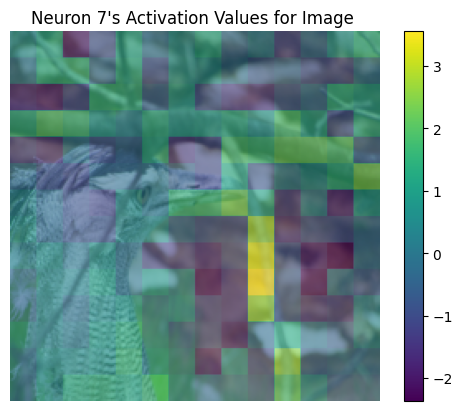

Class Name: bustard
Activation Value: 1.2605167627334595
Batch Index: 255



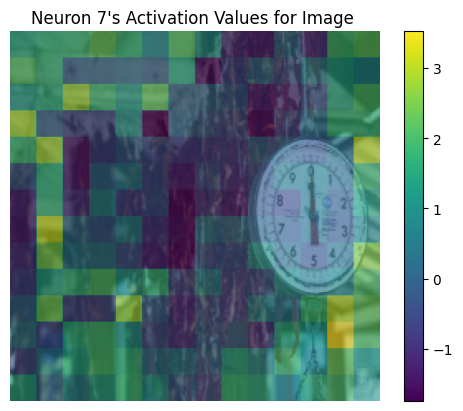

Class Name: scale
Activation Value: 1.240002155303955
Batch Index: 318



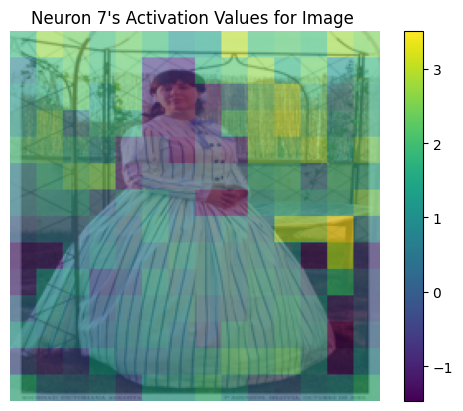

Class Name: hoopskirt
Activation Value: 1.228288173675537
Batch Index: 157



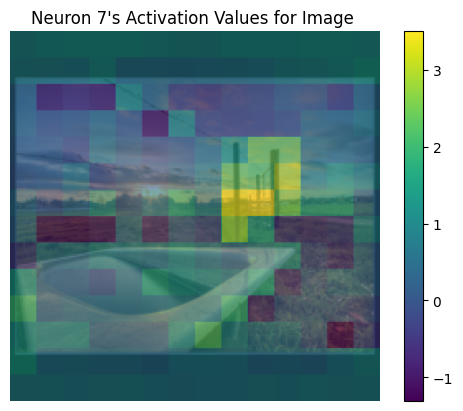

Class Name: tub
Activation Value: 1.2243452072143555
Batch Index: 58



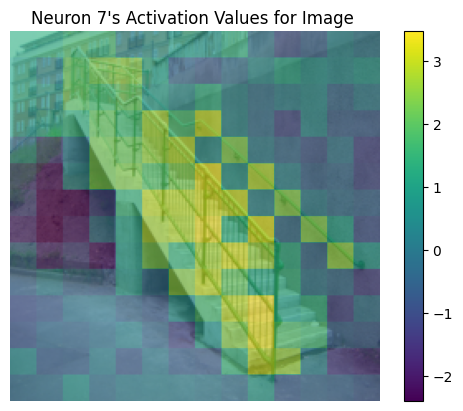

Class Name: bannister
Activation Value: 1.200019359588623
Batch Index: 419



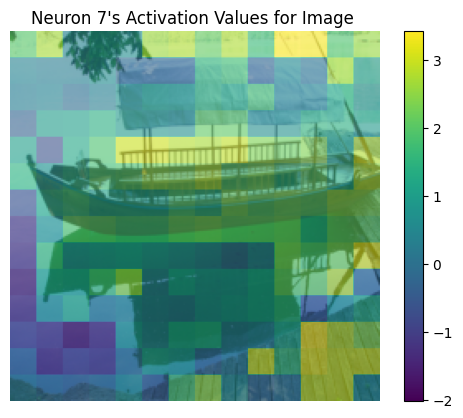

Class Name: gondola
Activation Value: 1.1670916080474854
Batch Index: 367



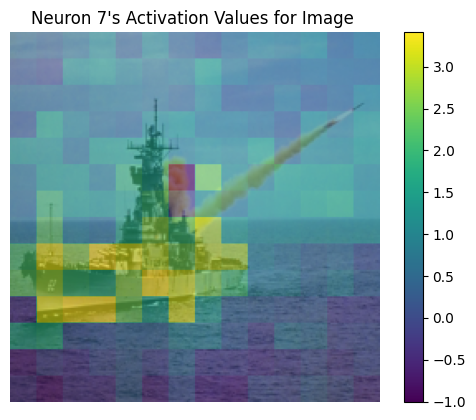

Class Name: projectile
Activation Value: 1.1652661561965942
Batch Index: 64



In [18]:
# Get top 10 class names, no duplicates
import matplotlib.pyplot as plt

specific_neuron_idx = 7

unique_top_entries = sorted_df[sorted_df['neuron_idx'] == specific_neuron_idx].drop_duplicates(subset='class_name').head(30)

# Extracting class names and activation values
unique_top_class_names = unique_top_entries['class_name'].tolist()
unique_top_activations = unique_top_entries['activation_value'].tolist()
unique_top_batch_idx = unique_top_entries['batch_idx'].tolist()

# Lists are ready to use
print("Top 10 Unique Class Names:", unique_top_class_names)
print("Corresponding Activations:", unique_top_activations)
print("Corresponding Batch Indices:", unique_top_batch_idx)


# Now plot

for i, batch_idx in enumerate(unique_top_batch_idx):
    image, activation_values_array = get_image_and_activations_by_id(specific_neuron_idx, batch_idx)
    plot_image_patch_heatmap(activation_values_array, image, specific_neuron_idx, image_size=224)
    print("Class Name:", unique_top_class_names[i])
    print("Activation Value:", unique_top_activations[i])
    print("Batch Index:", unique_top_batch_idx[i])
    print("")
# image, activation_values_array = get_image_and_activations_by_id(specific_neuron_idx, unique_top_batch_idx[0])
# plot_image_patch_heatmap(activation_values_array, image, specific_neuron_idx, image_size=224)